In [1]:
import PIL
from keras import models
from keras import layers
from tensorflow.keras import optimizers
import os
import glob
import shutil
import sys
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
import os
from tensorflow.keras import callbacks
import pandas as pd
from keras.utils import generic_utils


os.environ["CUDA_VISIBLE_DEVICES"]=" "

from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

batch_size = 16
epochs = 200

In [2]:
from efficientnet.keras import EfficientNetB5 as Net
from efficientnet.keras import center_crop_and_resize, preprocess_input

import efficientnet.tfkeras as efn
conv_base = efn.EfficientNetB5(weights='imagenet')
height = width = conv_base.input_shape[1]
input_shape = (height, width, 3)

# loading pretrained conv base model
conv_base = efn.EfficientNetB5(weights='imagenet', include_top=False, input_shape=input_shape)
# create new model with a new classification layer
x = conv_base.output  
global_average_layer = layers.GlobalAveragePooling2D(name = 'head_pooling')(x)
dropout_layer_1 = layers.Dropout(0.50,name = 'head_dropout')(global_average_layer)
prediction_layer = layers.Dense(2, activation='softmax',name = 'prediction_layer')(dropout_layer_1)

model = models.Model(inputs= conv_base.input, outputs=prediction_layer) 
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 456, 456, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 228, 228, 48) 1296        input_2[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 228, 228, 48) 192         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 228, 228, 48) 0           stem_bn[0][0]                    
______________________________________________________________________________________________

Total params: 28,517,618
Trainable params: 28,344,882
Non-trainable params: 172,736
__________________________________________________________________________________________________


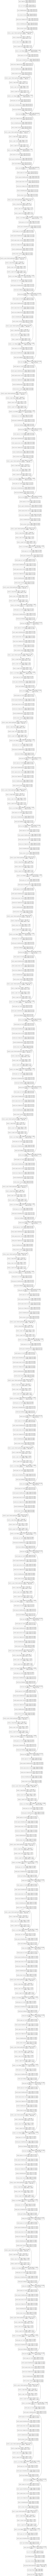

In [3]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [4]:
#showing before&after freezing
print('This is the number of trainable layers '
      'before freezing the conv base:', len(model.trainable_weights))
#conv_base.trainable = False  # freeze เพื่อรักษา convolutional base's weight
for layer in conv_base.layers:
    layer.trainable = False
print('This is the number of trainable layers '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable layers before freezing the conv base: 506
This is the number of trainable layers after freezing the conv base: 2


In [6]:
#Unfreez
model.trainable = True
set_trainable = False
for layer in model.layers:
    if layer.name == 'block5a_se_excite':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
print('This is the number of trainable layers '
      'after freezing the conv base:', len(model.trainable_weights))  

This is the number of trainable layers after freezing the conv base: 242
